# Sub-sampling from original file
Original WARC files are about 30GB of webpages. So i am going to take 100k of sample from it.

In [26]:
!pip install warcio tqdm pandas matplotlib humanize

In [4]:
from warcio.archiveiterator import ArchiveIterator
from warcio.recordloader import ArcWarcRecord
from warcio.warcwriter import WARCWriter
import os
from tqdm import tqdm

# Input and output file paths
websites_file = "./websites/all-websites.txt"
warc_directory = "./data"
output_warc_file = "website_data.warc"

# Load all URLs from the websites file
with open(websites_file, "r") as f:
    target_urls = set(line.strip() for line in f if line.strip())

# Create a proper WARC writer with UTF-8 handling
with open(output_warc_file, "wb") as output_file:
    # encoding_errors='replace' parametresi ekleyelim
    writer = WARCWriter(output_file, gzip=False, encoding_errors='replace')
    
    # Iterate through all WARC files in the specified directory
    for warc_file in tqdm(os.listdir(warc_directory), desc="Processing WARC files"):
        if warc_file.endswith(".warc"):
            warc_path = os.path.join(warc_directory, warc_file)
            with open(warc_path, "rb") as warc_stream:
                # Process each record in the WARC file
                for record in ArchiveIterator(warc_stream):
                    if record.rec_type == "response":
                        url = record.rec_headers.get_header("WARC-Target-URI")
                        if any(target in url for target in target_urls):
                            try:
                                # Correctly write the record with its headers
                                writer.write_record(record)
                            except Exception as e:
                                print(f"Error writing record for URL {url}: {str(e)}")

Processing WARC files:  29%|██▉       | 9/31 [03:45<09:14, 25.21s/it]

Error writing record for URL https://golazo.ro/carlsen-nepo-sah-titlul-mondial-niemann-121647: 'ascii' codec can't encode character '\u0219' in position 309: ordinal not in range(128)
Error writing record for URL https://golazo.ro/stephane-omeonga-serie-a-politia-italiana-scotia-italia-121652: 'ascii' codec can't encode character '\xe9' in position 303: ordinal not in range(128)


Processing WARC files:  81%|████████  | 25/31 [11:02<02:51, 28.66s/it]

Error writing record for URL https://golazo.ro/dan-sucu-genoa-serie-a-italia-gaetano-mocciaro-121690: 'ascii' codec can't encode character '\u0219' in position 301: ordinal not in range(128)
Error writing record for URL https://golazo.ro/denis-ciobotariu-sepsi-rapid-omar-el-sawy-liga-1-121702: 'ascii' codec can't encode character '\xee' in position 312: ordinal not in range(128)
Error writing record for URL https://golazo.ro/new-orleans-masacru-sugar-bowl-fotbal-american-121714: 'ascii' codec can't encode character '\u021b' in position 305: ordinal not in range(128)
Error writing record for URL https://golazo.ro/rangers-celtic-glasgow-gica-hagi-ianis-hagi-ibrox-stadium-121721: 'ascii' codec can't encode character '\u0103' in position 304: ordinal not in range(128)


Processing WARC files: 100%|██████████| 31/31 [24:18<00:00, 47.06s/it] 


### Sample Statistics

WARC dosyaları istatistikleri hesaplanıyor...


Dosyalar: 100%|██████████| 31/31 [10:16<00:00, 19.88s/it]



### WARC Dosya İstatistikleri ###
Toplam dosya sayısı: 31
Toplam dosya boyutu: 37.5 GB
Toplam kayıt sayısı: 1621629

Kayıt Türleri Dağılımı:
  - request: 810799 (50.00%)
  - response: 810797 (50.00%)
  - warcinfo: 31 (0.00%)
  - resource: 2 (0.00%)

En Yaygın İçerik Türleri (ilk 10):
  - text/html: 807240
  - text/HTML: 606
  - image/webp: 121
  - application/atom+xml: 71
  - application/json: 68
  - text/html, charset=iso-8859-1: 24
  - application/pdf: 5
  - application/xml: 3
  - image/jpeg: 3
  - application/x-www-form-urlencoded: 2

En Yaygın HTTP Durum Kodları:
  - 200: 810797

En Yaygın Domainler (ilk 10):
  - familio.org: 29673
  - webcatalog.io: 24311
  - thetibetpost.com: 21395
  - www.mexc.com: 19736
  - news.livedoor.com: 17898
  - www.zazoom.it: 14853
  - mirtesen.ru: 14158
  - www.mexc.co: 9231
  - dientuungdung.vn: 7336
  - www.sondakika.com: 5670

Ortalama URL uzunluğu: 107.86 karakter


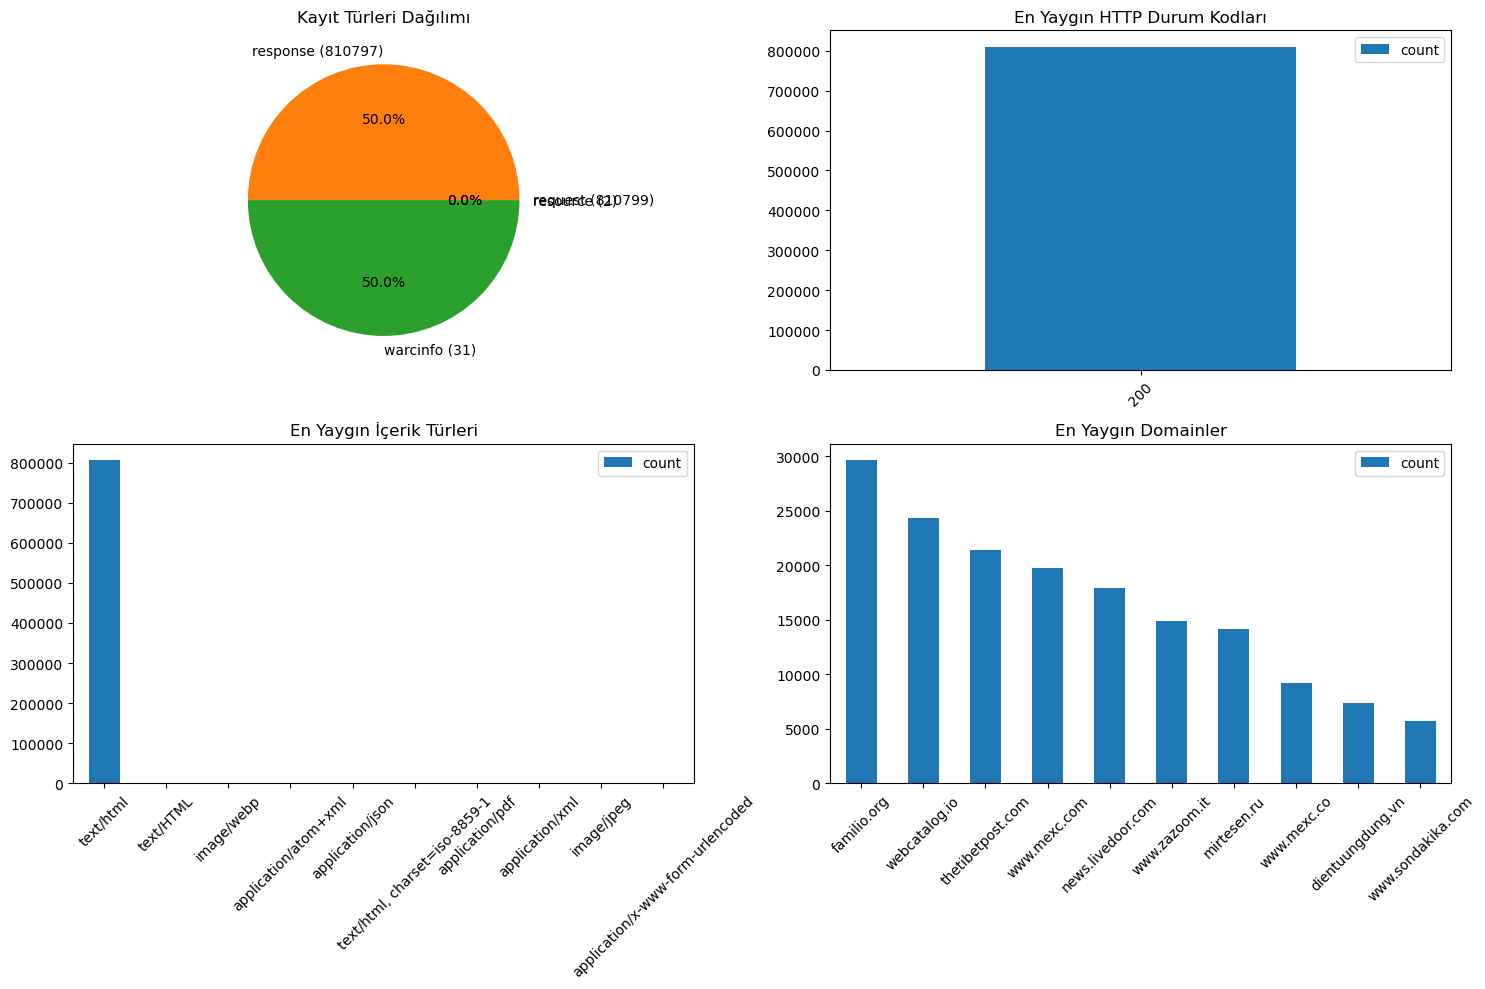

In [5]:
from warcio.archiveiterator import ArchiveIterator
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import humanize

# WARC dizini
warc_directory = "./data"

# İstatistik değişkenleri
total_files = 0
total_size = 0
total_records = 0
record_types = Counter()
content_types = Counter()
status_codes = Counter()
domain_counter = Counter()
url_lengths = []

# URL'den domain çıkarmak için yardımcı fonksiyon
def extract_domain(url):
    try:
        from urllib.parse import urlparse
        return urlparse(url).netloc
    except:
        return "unknown"

print("WARC dosyaları istatistikleri hesaplanıyor...")

# Tüm WARC dosyalarını işle
warc_files = [f for f in os.listdir(warc_directory) if f.endswith(".warc")]
for warc_file in tqdm(warc_files, desc="Dosyalar"):
    total_files += 1
    warc_path = os.path.join(warc_directory, warc_file)
    file_size = os.path.getsize(warc_path)
    total_size += file_size
    
    with open(warc_path, "rb") as warc_stream:
        # Her bir kaydı işle
        for record in ArchiveIterator(warc_stream):
            total_records += 1
            record_types[record.rec_type] += 1
            
            # Response kayıtları için ek bilgiler topla
            if record.rec_type == "response":
                url = record.rec_headers.get_header("WARC-Target-URI")
                if url:
                    domain = extract_domain(url)
                    domain_counter[domain] += 1
                    url_lengths.append(len(url))
                
                # HTTP durum kodları ve içerik türleri
                if record.http_headers:
                    status = record.http_headers.get_statuscode()
                    if status:
                        status_codes[status] += 1
                    
                    content_type = record.http_headers.get_header("Content-Type")
                    if content_type:
                        # Sadece ana içerik türünü al (örn: text/html -> text)
                        main_type = content_type.split(';')[0].strip()
                        content_types[main_type] += 1

# Sonuçları göster
print(f"\n### WARC Dosya İstatistikleri ###")
print(f"Toplam dosya sayısı: {total_files}")
print(f"Toplam dosya boyutu: {humanize.naturalsize(total_size)}")
print(f"Toplam kayıt sayısı: {total_records}")

print("\nKayıt Türleri Dağılımı:")
for rec_type, count in record_types.most_common():
    print(f"  - {rec_type}: {count} ({count/total_records*100:.2f}%)")

print("\nEn Yaygın İçerik Türleri (ilk 10):")
for content_type, count in content_types.most_common(10):
    print(f"  - {content_type}: {count}")

print("\nEn Yaygın HTTP Durum Kodları:")
for status, count in status_codes.most_common():
    print(f"  - {status}: {count}")

print("\nEn Yaygın Domainler (ilk 10):")
for domain, count in domain_counter.most_common(10):
    print(f"  - {domain}: {count}")

# Ortalama URL uzunluğu
if url_lengths:
    avg_url_length = sum(url_lengths) / len(url_lengths)
    print(f"\nOrtalama URL uzunluğu: {avg_url_length:.2f} karakter")

# Grafikler
plt.figure(figsize=(15, 10))

# Kayıt türleri pasta grafiği
plt.subplot(2, 2, 1)
labels = [f"{k} ({v})" for k, v in record_types.most_common()]
plt.pie(record_types.values(), labels=labels, autopct='%1.1f%%')
plt.title('Kayıt Türleri Dağılımı')

# HTTP durum kodları bar grafiği
plt.subplot(2, 2, 2)
status_df = pd.DataFrame.from_dict(status_codes, orient='index', columns=['count']).sort_values('count', ascending=False).head(10)
status_df.plot(kind='bar', ax=plt.gca())
plt.title('En Yaygın HTTP Durum Kodları')
plt.xticks(rotation=45)

# İçerik türleri bar grafiği
plt.subplot(2, 2, 3)
content_df = pd.DataFrame.from_dict(content_types, orient='index', columns=['count']).sort_values('count', ascending=False).head(10)
content_df.plot(kind='bar', ax=plt.gca())
plt.title('En Yaygın İçerik Türleri')
plt.xticks(rotation=45)

# Domainler bar grafiği
plt.subplot(2, 2, 4)
domain_df = pd.DataFrame.from_dict(domain_counter, orient='index', columns=['count']).sort_values('count', ascending=False).head(10)
domain_df.plot(kind='bar', ax=plt.gca())
plt.title('En Yaygın Domainler')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

'website_data.warc' dosyasının istatistikleri hesaplanıyor...


Kayıtlar: 98985it [00:36, 2695.95it/s]



### 'website_data.warc' Dosyası İstatistikleri ###
Dosya boyutu: 16.3 GB
Toplam kayıt sayısı: 98985

Kayıt Türleri Dağılımı:
  - response: 98985 (100.00%)

En Yaygın İçerik Türleri (ilk 10):
  - text/html: 97978
  - text/HTML: 606
  - image/webp: 121
  - application/atom+xml: 68
  - application/json: 68
  - application/pdf: 4
  - image/jpeg: 1

En Yaygın HTTP Durum Kodları:
  - 200: 98985

En Yaygın Domainler (ilk 10):
  - webcatalog.io: 24311
  - www.sondakika.com: 5670
  - www.goal.com: 4414
  - www.finanznachrichten.de: 3064
  - quran.com: 2621
  - www.haberler.com: 2469
  - www.haberturk.com: 1915
  - www.dw.com: 1626
  - dunya.com.pk: 1384
  - www.augsburger-allgemeine.de: 1230

Ortalama URL uzunluğu: 98.02 karakter


Text(0.5, 1.0, 'En Yaygın İçerik Türleri')

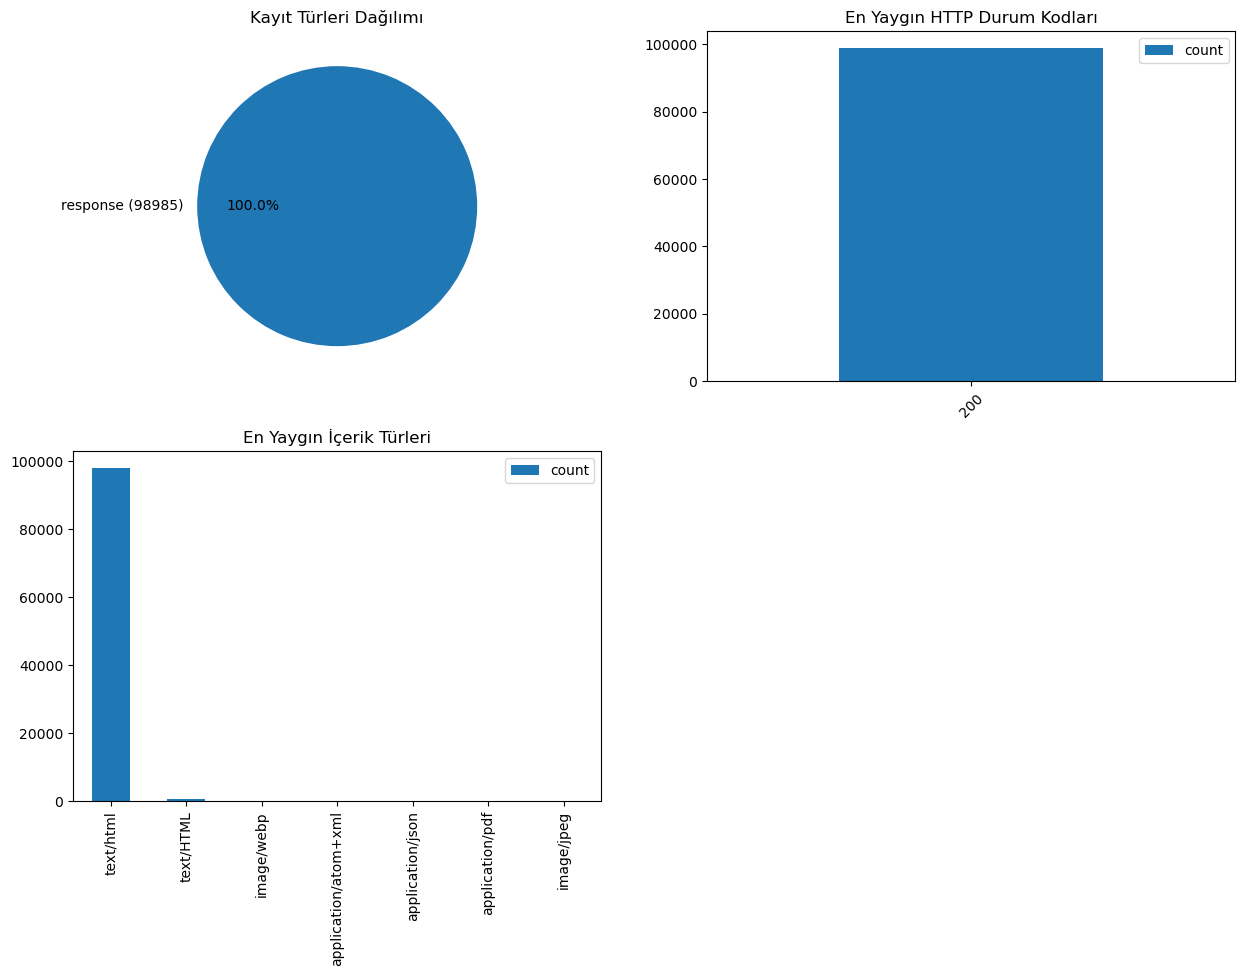

In [6]:
from warcio.archiveiterator import ArchiveIterator
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import humanize

# Analiz edilecek WARC dosyası
warc_file = "website_data.warc"

# İstatistik değişkenleri
total_size = 0
total_records = 0
record_types = Counter()
content_types = Counter()
status_codes = Counter()
domain_counter = Counter()
url_lengths = []

# URL'den domain çıkarmak için yardımcı fonksiyon
def extract_domain(url):
    try:
        from urllib.parse import urlparse
        return urlparse(url).netloc
    except:
        return "unknown"

print(f"'{warc_file}' dosyasının istatistikleri hesaplanıyor...")

# Dosya boyutu
file_size = os.path.getsize(warc_file)
total_size = file_size

# WARC dosyasını işle
with open(warc_file, "rb") as warc_stream:
    # Her bir kaydı işle
    for record in tqdm(ArchiveIterator(warc_stream), desc="Kayıtlar"):
        total_records += 1
        record_types[record.rec_type] += 1
        
        # Response kayıtları için ek bilgiler topla
        if record.rec_type == "response":
            url = record.rec_headers.get_header("WARC-Target-URI")
            if url:
                domain = extract_domain(url)
                domain_counter[domain] += 1
                url_lengths.append(len(url))
            
            # HTTP durum kodları ve içerik türleri
            if record.http_headers:
                status = record.http_headers.get_statuscode()
                if status:
                    status_codes[status] += 1
                
                content_type = record.http_headers.get_header("Content-Type")
                if content_type:
                    # Sadece ana içerik türünü al (örn: text/html -> text)
                    main_type = content_type.split(';')[0].strip()
                    content_types[main_type] += 1

# Sonuçları göster
print(f"\n### '{warc_file}' Dosyası İstatistikleri ###")
print(f"Dosya boyutu: {humanize.naturalsize(total_size)}")
print(f"Toplam kayıt sayısı: {total_records}")

print("\nKayıt Türleri Dağılımı:")
for rec_type, count in record_types.most_common():
    print(f"  - {rec_type}: {count} ({count/total_records*100:.2f}%)")

print("\nEn Yaygın İçerik Türleri (ilk 10):")
for content_type, count in content_types.most_common(10):
    print(f"  - {content_type}: {count}")

print("\nEn Yaygın HTTP Durum Kodları:")
for status, count in status_codes.most_common():
    print(f"  - {status}: {count}")

print("\nEn Yaygın Domainler (ilk 10):")
for domain, count in domain_counter.most_common(10):
    print(f"  - {domain}: {count}")

# Ortalama URL uzunluğu
if url_lengths:
    avg_url_length = sum(url_lengths) / len(url_lengths)
    print(f"\nOrtalama URL uzunluğu: {avg_url_length:.2f} karakter")

# Grafikler
plt.figure(figsize=(15, 10))

# Kayıt türleri pasta grafiği
plt.subplot(2, 2, 1)
labels = [f"{k} ({v})" for k, v in record_types.most_common()]
plt.pie(record_types.values(), labels=labels, autopct='%1.1f%%')
plt.title('Kayıt Türleri Dağılımı')

# HTTP durum kodları bar grafiği
plt.subplot(2, 2, 2)
status_df = pd.DataFrame.from_dict(status_codes, orient='index', columns=['count']).sort_values('count', ascending=False).head(10)
status_df.plot(kind='bar', ax=plt.gca())
plt.title('En Yaygın HTTP Durum Kodları')
plt.xticks(rotation=45)

# İçerik türleri bar grafiği
plt.subplot(2, 2, 3)
content_df = pd.DataFrame.from_dict(content_types, orient='index', columns=['count']).sort_values('count', ascending=False).head(10)
content_df.plot(kind='bar', ax=plt.gca())
plt.title('En Yaygın İçerik Türleri')